### Import packages

In [1]:
import json
import pandas as pd
from pandas import json_normalize
from mplsoccer import Pitch
import matplotlib.pyplot as plt
import numpy as np

/Users/rolandkovacs/Documents/repos/friends_of_tracking/friends_of_tracking/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Find match ids

In [2]:
# competition_id = 43
# with open('./../statsbomb_wc/open-data-master/data/matches/'+str(competition_id)+'/106.json') as f:
#     matches = json.load(f)

# #Find the matches they played
team = 'Argentina'
# home_ids = [match['match_id'] for match in matches if match['home_team']['home_team_name'] == team]
# away_ids = [match['match_id'] for match in matches if match['away_team']['away_team_name'] == team]
# match_ids = home_ids + away_ids
match_ids = [3857289, 3869685, 3869519, 3869151, 3857300, 3869321, 3857264]

### Create data

In [9]:
def load_data(match_id, team):
    file_name = str(match_id)+'.json'
    with open('./../data/'+file_name) as data_file:
        data = json.load(data_file)
    df = json_normalize(data, sep = "_").assign(match_id = file_name[:-5])
    return df[df['team_name']==team]

def create_event_df(df, event):
    events = df[df['type_name']==event].copy()
    events['time'] = events['minute'] * 60 + events['second']
    return events

def is_within_timeframe(pass_row, shots_df):
    pass_time = pass_row['time']
    period = pass_row['period']
    relevant_shots = shots_df.loc[(shots_df['period'] == period) & 
                                    (shots_df['time'] >= pass_time) & 
                                    (shots_df['time'] <= pass_time + 10)]
    return not relevant_shots.empty

dangerous_passes_df = pd.DataFrame()

for match_id in match_ids:

    df = load_data(match_id, team)

    passes_df = create_event_df(df, 'Pass')
    shots_df = create_event_df(df, 'Shot')

    passes_df.loc[:,'is_within_timeframe'] = passes_df.apply(lambda row: is_within_timeframe(row, shots_df), axis=1)

    passes_df = passes_df[(passes_df.is_within_timeframe==True)&(passes_df.pass_type_name!='Corner')]

    dangerous_passes_df = pd.concat([dangerous_passes_df, passes_df], ignore_index=True)

print(f"There were {len(dangerous_passes_df)} dangerous passes for {team}.")

There were 185 dangerous passes for Argentina.


### Visualize passes

In [23]:
def create_pitch(pitch_color, line_color):
    pitch = Pitch(pitch_type='statsbomb', pitch_color=pitch_color, line_color=line_color)
    fig, axs = pitch.grid(figheight=6, title_height=0.05, endnote_space=0, axis=False, 
                    title_space=0, grid_height=0.82, endnote_height=0.01)
    fig.set_facecolor(pitch_color)

    return fig, axs

Text(0.5, 0.2, 'Argentina dangerous passes - Word Cup 2023')

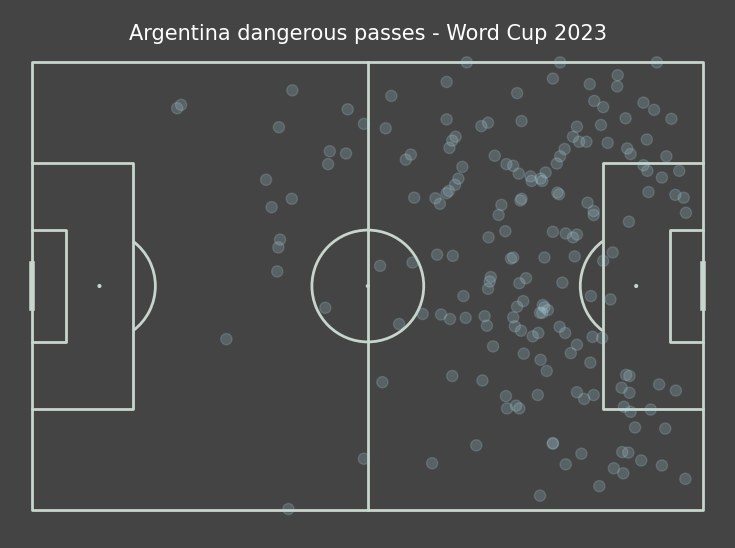

In [24]:
line_color = '#c7d5cc'
pitch_color = '#444444'
pitch_width_y = 80

fig, axs = create_pitch(pitch_color, line_color)

for i, d_pass in dangerous_passes_df.iterrows():
    x = d_pass['location'][0]
    y = pitch_width_y - d_pass['location'][1]
    pass_circle = plt.Circle((x, y), 1, color="#ADD8E6")
    pass_circle.set_alpha(.2)   
    axs['pitch'].add_patch(pass_circle)

title = f"{team} dangerous passes - Word Cup 2023"
axs['title'].text(0.5, 0.2, title, color='w',
                    va='center', ha='center', fontsize=15) 
# fig.set_size_inches(10, 7)

### Heatmap

Text(0.73, 2, 'Data by StatsBomb')

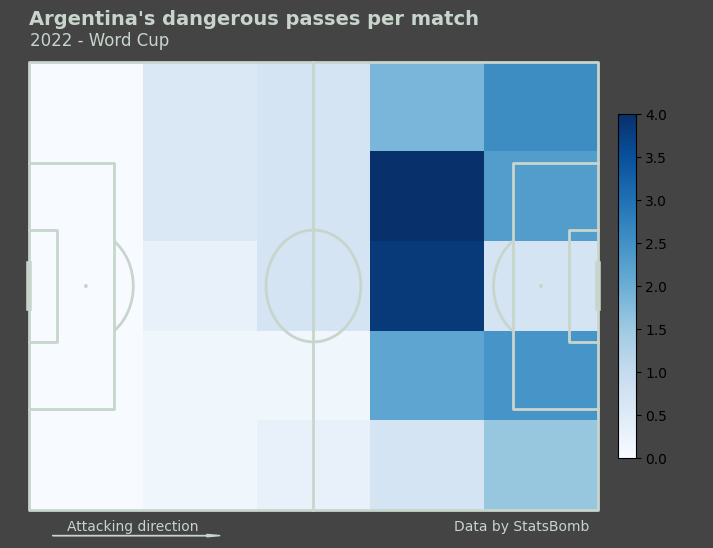

In [65]:
number_of_matches = len(match_ids)
pitch_length_x = 120
pitch_width_y = 80

x, y = [], []
for p in dangerous_passes_df.location:
    x.append(p[0])
    y.append(pitch_width_y - p[1])

hist_passes = np.histogram2d(y, x, bins = 5, range = [[0, pitch_width_y], [0, pitch_length_x]])

fig, axs = create_pitch(pitch_color, line_color)

pos = axs['pitch'].imshow(hist_passes[0]/number_of_matches, extent = [0,120,0,80], aspect = 'auto', cmap = plt.cm.Blues, origin='lower')
fig.colorbar(pos, ax=axs['pitch'], shrink=0.7, pad=0.002)

title = "Argentina's dangerous passes per match"
subtitle = "2022 - Word Cup"
axs['title'].text(0.33, 0.7, title, color = line_color, va='center', ha='center', fontsize = 14, fontweight='bold')
axs['title'].text(0.1, 0.0, subtitle, color = line_color, va='center', ha='center', fontsize = 12)

axs['endnote'].set_xlim(0, 1)
axs['endnote'].set_ylim(0, 1)
axs['endnote'].text(0.15, 2, 'Attacking direction', va = 'center', ha = 'center', color = line_color, fontsize = 10)
axs['endnote'].arrow(0.03, 0.4, 0.23, 0, width  = 0.001, head_width = 0.4, head_length = 0.02, ec = line_color, fc = line_color)

axs['endnote'].text(0.73, 2, 'Data by StatsBomb', va = 'center', ha = 'center', color = line_color, fontsize = 10)